## Setup Steps

- Open Jupyter Lab via. https://hemera5.fz-rossendorf.de/ or open your private Jupyter Lab
- Open a Terminal in Jupyter Lab for commands
- Make a symlink: ln -s /bigdata/flotsim   # Later in Jupyter Lab: /home/beyer83/bigdata/flotsim available <br>
    
#### Setup Anaconda environment for Jupyter Lab
- see: https://fwcc.pages.hzdr.de/infohub/hpc/interactive.html#kernelpic
- module load anaconda
- conda init bash
- exec bash
- conda create -n 'BubbleSeg' python=3.10.4
- conda activate BubbleSeg
- pip install ipython ipywidgets==7.7.0 pillow numpy matplotlib tqdm opencv-contrib-python scikit-image gputils albumentations
- conda install ipykernel ipython_genutils

##### Install Tensorflow and Stardist
- https://www.tensorflow.org/install/pip
- conda install -c conda-forge cudatoolkit=11.8.0
- pip install nvidia-cudnn-cu11==8.6.0.163
- pip install tensorflow==2.13.*
- pip install stardist

##### Check for GPU (On Jupyter Session with GPU):
- nvidia-smi
- print(tf.config.list_physical_devices('GPU')) --> [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##### Build Kernel Jupyter Interface
- python -m ipykernel install --user --name BubbleSeg --display-name 'BubbleSeg'
- Activate Anaconda env in Jupyter Lab: Kernel --> Change Kernel --> BubbleSeg

<hr>
<hr>

## Sources: 
   - Utility: ChatGPT
   - IPywidets: https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html#Tabs
   - skimage: https://scikit-image.org/docs/stable/api/api.html
   - Stardist: https://github.com/stardist/stardist
   - Stardist: https://www.youtube.com/watch?v=Amn_eHRGX5M
   - Stardist Examples: https://github.com/stardist/stardist/blob/master/examples
   
<hr>
<hr>

## Guide to Data
  - try to look into the data before reading the specific details of this guide.
  - Skim the PDF and Excel documentation and try the notebook for exploratory data analysis.
    
### Data Description
  - For every of 62 experiments up to 50000 .npy grayscale images were saved.
  - All images have the shape (2056, 2464,1) and occupy ~4.8 MB of disk space.
  - Camera 'ABE' records from the top; camera '253' records from the side through a plexiglass tube.
  - Each experiment changes bubble parameters (look in Excel file); they still look nearly the same.
  - In each experiment 4  different types of concentrates are tested; they represent how crushed minerals are extracted.
  - There are missing pictures, the camera timestamps are broken, the cameras do NOT record in sync.
  - A froth scraper occasionally scrapes of old froth, darkening the image and resetting the bubble buildup.
   
### Findings from Data Analysis
  - Data is extremly diverse!
  - Bubbles can be foamy, dark, bright, squished, transparent, bursting, round, polygonal and blurred
  - Images have a lot of hidden noise --> Edge detection filters fail
  - In edge cases bubbles can be slightly larger than 512x512 pixels. (just 3 instances were found in experiment 20)
  - Bubble sizes range from 5 to 600 pixels.
  - There can be 5 - 350 bubbles instances per 512x512 image.
  - Every bubble has a reflection point and varying outline reflection

#### What did not work:
  - Edge detection (too noisy)
  - Sharpening (removes details, noise only a small problem)
  - Noise reduction with Non-Local Means (removes details from bubbles irregularily, removes small bubbles)
        
#### Concentrate 1:
   - Nearly impossible to label. Has very distorted bubbles completly covered in dust.
        
#### Concentrate 2:
   - Has a lot of dust froth several mm thick.
   - Has bubble sizes from small to large
   - This froth covers most of the bubbles. Often only the top of bubbles is visible.

#### Concentrate 3:
   - Concentrate with the most bubble types
   - Bubble types range from slightly foamy to dusty to nearly clear.
   - Has bubble sizes from fine to large.
   
#### Concentrate 4:
   - Concentrate with super transparent bubbles, 2nd layer bubbles are clearly visible but not of interest!
   - All bubbles are clear with sizes from fine to large.
   
<hr>
<hr>

## Guide to Data Preparation

### Data Format for Stardist
   - Checkout: https://github.com/stardist/stardist and https://www.youtube.com/watch?v=Amn_eHRGX5M
   - Only .tif images!
   - Stardist needs square train images of side lengths like [124,248,512,1024,...].
   - Usually 100 instances per class are enough for Stardist with its U-Net model structure.
   - Instances need to be star-convex

### Model Inference:
   - It is planned to have one separate model per camera and concentrate as this improves accuracy.
   - Concentrate 1 will not be used as its data is nearly unusable.
   - This leaves the concentrate models [ABE_c2, ABE_c3, ABE_c4, 253_c2, 253_c3, 253_c4]
   - Optionally entire camera models can be trained for easier usage: [ABE_c2,c3,c4, 253_c2,c3,c4, ABE,253_c2,c3,c4]

### How to Handpick the Right Data
   - Use the handy UI below to download image subsamples!
   - Handpick separately for each camera ID and concentrate
   - For experiment 20 concentrate numbers are noted as follows: {c1 : 0-2920, c2 : 2920-4720, c3 : 4720-11860, c4 : 11860-end}
   - If handpicking from other experiments, please fill in the threshold inside the functinon download_handpick_img()!
   - Make sure to extract a lot of pictures with big bubbles as they there are maybe just 2-5 instance per image!
   - Make sure to include examples for all the bubble types, if very accurate predictions are wished:
   - Thus Include tiny, small, big, foamy, dark, bright, squished, transparent, bursting, round, polygonal and blurred bubbles!
   - May pick subsamples of start and end of concentrate phases (early phases have more dust which cahnges with time)!
   - Include subsamples from multiple parts of the image (top, botton, left, rigth, ...): different blur, lighting and squishing.
   - There is may no big need to pick data from more than one experiment setting.
   
#### Handpicked Data

   - about 40-60 images were picked for each of the six model-concentrate combinations
   - Its goal is to include enough diverse bubble structures that can easily be picked for labeling

### How Label the Data
   - Label images with Fiji, Labkit, or QuPath (QuPath seems the best)
   - 15 to 25 images are enough per camera-concentrate
   - Only label the 1st layer bubbles, ignore bubbles below
   - Label all parts of 1st layer bubbles: Label parts of 1st layer bubbles covered by froth or other transparent bubbles
   - Do not try to label data that is impossible to label
   - Plan to spend 1.5 or even 3.0 hours to label a single picture!
   - The smallest bubbles you have to label are about 4x4 pixels and generally all that can be recognized by the human eye!
   
### Adjust Current Labels
   - Open the QuPath project file with QuPath to see and adjust the labels
   - The image loading paths may be changed. On opening the project a window opens highlighting the missing paths.
   - QuPath is pretty good at recognizing the changed image file paths. If it recognized the paths, you can easily use the proposed replacement URIs.
   - If no replacement URIs show up, drag the handpicked images with the correct name into this window and the correct replacement URIs show up.
   - Now, drag every handpicked images to this window
   
   
  
#### Exporting Binary masks:
   - If using QPath use this script: https://github.com/stardist/stardist/blob/master/extras/qupath_export_annotations.groovy
   - Else refer to: https://github.com/stardist/stardist#annotating-images
   
#### Labeled Data

   - Labels are available in QPath project files and can easily be corrected.
   - Please consider to check all images for missing labels before the downstream applciation, especially for c2 where a lot of 4x4 to 10x10 bubbles can easily be missed!
   - Also consider annotating a few more images for testing and for validation! Currently all 10 images are used solely for training!
   - One model should have around 25 images so that tiny, small, medium and especially big bubbles can be accurately predicted.
   - Only 10 images just for concentrates c2 and c4 are labeled (takes very long: 1.5 to 3 hours per image!)
   - Images for validation and testing could be picked too, later.
   - Currently labeled images are {ABE_c1 : [], ABE_c2 : [1,2,3,4,8,11,18], ABE_c3 : [], ABE_c4 : [31,38,41], 253_c1 : [], 253_c2 : [], 253_c3 : [], 253_c4 : []}
   
<hr>
<hr>

## Results:
   - The first model prototype already yields good predictions for cam ABE.
   - It can classify common bubble types pretty accurate and is even able to classify images of camera 253 slightly well.
   - Predictions are especially inaccurate for big bubbles, transparent bubbles, frothy bubbles, dark bubbles, tiny bubbles as these were not abundantly present in the training data at all.
   - Make sure to label more images with these bubble types!
   - The model sees bubbles on dark or gray edges of the experiment setup.
   - Add these areas definetly to your training data and maybe handpick a nealy black area!
    
### Further improvements:
   - Actually train the model until it actually converges (model could only be trained for 250 epochs before 9h time out)
   - Manage to setup a GPU support for Stardist (failed because of CuDNN version mismatch for us)
   - If wished to analyze the bubbles even while froth-scraping, it will need an additional +7 images for models to learn the scraper interference!
   - Else exclude every froth-scraping image from analysis!
   - May correct some of the labelings for the few small bubbles that are missing a label. 
   - Else, the model will predict small bubbles less often!
   - Validation data was not present to determine the best model epochs! Include +5 val pictures.
   - When validation data is present, uncomment the line "model.optimize_thresholds(val_x, val_y)" to improve model performance.
   - The model cannot predict the occasional enormous bubbles of over 512x512 pixels. If the labeling labour is really worth it, train Stardist with 1024x1024 images.
   - See these enourmous bubbles, for example, at [E20_ABE_img5329, E20_253_img19580, E15_ABE_img4912, ...]
   
### Further Work:
   - Finish Starist work as described above.
   - May use Multistar for overlapping instance segmentation.
   
#### Considerations for Multistar
   - The labels need to be reworked to consider bubbles under the first layer of bubbles (2nd layer bubbles are new instances)
   - It might work more well to analyze the bubble images, if 1st and 2nd and 3rd layer can be distinguished
   - There is only the Multistar paper and a less well documented simple GitHub reposotory.
   
<hr>
<hr>

In [1]:
import ipywidgets as widgets 
from IPython.display import display, clear_output
from IPython.display import Image as IPython_Image
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available, relabel_image_stardist
from stardist.models import Config2D, StarDist2D, StarDistData2D
import albumentations as A
from PIL import Image as PIL_Image
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import time
from tqdm import tqdm
from tifffile import imread
import io
import cv2
import skimage
from skimage import filters, feature
from csbdeep.utils import normalize
from csbdeep.data import Normalizer, normalize_mi_ma

2023-09-15 10:12:41.605134: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 10:12:42.889173: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<hr>
<hr>

In [2]:
#########################
### Utility Functions ###
#########################

def load_pic_data(messreihe, base_dir_path, cam_id, pic_num):
    dir_names = [name for name in os.listdir(base_dir_path) if f'_{messreihe}_' in name]
    if len(dir_names) == 0:
        print(f'No dirs found for {base_dir_path} and messreihe: {messreihe}.')
        return np.nan
    else:
        dir_name = dir_names[0]
        dir_path = f'{base_dir_path}/{dir_name}'
        fn = [name for name in os.listdir(dir_path) 
                        if (f'_{pic_num}_' in name) 
                       and (f'{cam_id})'   in name)]
        if len(fn) == 0:
            return np.nan # No picture exists for pic_num (out of range or measurement gap)
        else:
            fn = fn[-1] # -1 for latest experiment retake
            file_path = f'{dir_path}/{fn}'
            data = np.load(file_path)
            return data

def make_tiff(messreihe, base_dir_path, cam_id, pic_range): 
    pil_images = []
    if len(pic_range) > 800+1: # 800 --> ~4 GB
        raise Exception('Warning: TIFF files can only contain up to 800 grayscale imagese before reaching the file size limit!')
    for i in tqdm(pic_range, desc="Reading Images"): #
        img = load_pic_data(messreihe, base_dir_path, cam_id, pic_num=i) # This takes the most time! --> 95%
        img = np.squeeze(img, axis=-1) # shape (2056, 2464, 1) --> (2056, 2464)
        pil_images.append(PIL_Image.fromarray(img, mode='L')) # 'L' for grayscale images
        
    tiff  = PIL_Image.new('L', (pil_images[0].width, pil_images[0].height * len(pil_images)))
    for i, pil_image in enumerate(tqdm(pil_images, desc="Converting Images")):
        tiff.paste(pil_image, (0, i * pil_image.height))
    for i in tqdm(range(1), desc='Saving Images'):
        tiff.save('combined_image.tiff')
        
def make_png(messreihe, base_dir_path, cam_id, pic_range): 
    pil_images = []
    if len(pic_range) > 800+1: # 800 --> ~4 GB
        raise Exception('Warning: TIFF files can only contain up to 800 grayscale imagese before reaching the file size limit!')
    for i in tqdm(pic_range, desc="Reading Images"): #
        img = load_pic_data(messreihe, base_dir_path, cam_id, pic_num=i) # This takes the most time! --> 95%
        img = np.squeeze(img, axis=-1) # shape (2056, 2464, 1) --> (2056, 2464)
        pil_images.append(PIL_Image.fromarray(img, mode='L')) # 'L' for grayscale images
        
    tiff  = PIL_Image.new('L', (pil_images[0].width, pil_images[0].height * len(pil_images)))
    for i, pil_image in enumerate(tqdm(pil_images, desc="Converting Images")):
        tiff.paste(pil_image, (0, i * pil_image.height))
    for i in tqdm(range(1), desc='Saving Images'):
        tiff.save('combined_image.tiff')
        

<hr><hr>

## Interactive Dashboard for Instance Segmentation

#### Tab 1: Data Preview and Pre-Processing

<hr><hr>

In [3]:
####################################################
########### Defined Ipywidget Components ###########
####################################################

dropdown        = widgets.Dropdown(options=['ABE', '253'], description='Camera ID:')
input_path      = widgets.Text(value='/home/beyer83/flotsim/Camera_Outotec', description='base_dir_path:')
input_messreihe = widgets.IntSlider(value=20, min=1, max=62, description='Experiment Num.:')
input_pic_num   = widgets.IntSlider(value=1, description='Picture num:')
input_disp_size = widgets.FloatSlider(value=0.25, min=0.01, max=1, step=0.01, description='Display Size (%):')

button_save                = widgets.Button(description='Downl. Image')
button_recommended_fparams = widgets.Button(description='Use Rec. Filters')

########################
### Filter Accordion ###
########################

### Crop Filter
title_253 = widgets.HTML("<h2>CamID 253:</h2>")
range_slider_accordA_x_253 = widgets.IntRangeSlider(description=f'X Crop')
range_slider_accordA_y_253 = widgets.IntRangeSlider(description=f'Y Crop')

title_ABE = widgets.HTML("<h2>CamID ABE:</h2>")
range_slider_accordA_x_ABE = widgets.IntRangeSlider(description=f'X Crop')
range_slider_accordA_y_ABE = widgets.IntRangeSlider(description=f'Y Crop')

checkbox_accordA = widgets.Checkbox(value=False, description='Enabled')



### Defining the Filter Accordion ###
arcordion_crop_comps = widgets.VBox([checkbox_accordA,
                                        title_ABE, 
                                        range_slider_accordA_x_ABE, range_slider_accordA_y_ABE,
                                        title_253, 
                                        range_slider_accordA_x_253, range_slider_accordA_y_253,
                                        button_recommended_fparams])

accordion_children = [arcordion_crop_comps]



accordion = widgets.Accordion(children=accordion_children)
accordion.selected_index = None
for i, title in enumerate(['Crop']):
    accordion.set_title(index=i,title=title)
    
##########################
### Handpick Accordion ###
########################## 

checkbox_handpick = widgets.Checkbox(value=False, description='Enabled')

accordion_handpick_input_size = widgets.SelectionSlider(options=[128, 256, 512, 1024], value=512, description='Sample Size:')

accordion_handpick_input_Xoffset = widgets.IntSlider(value=1, min=0, max=1, description=f'Xoffset')
accordion_handpick_input_Yoffset = widgets.IntSlider(value=1, min=0, max=1, description=f'Yoffset')

accordion_handpick_button_downlaod = widgets.Button(description='Downl. Sample')
    
### Defining the Handpick Accordion ###
accordion_handpick_children =  widgets.VBox([checkbox_handpick, accordion_handpick_input_size, 
                                             accordion_handpick_input_Xoffset, accordion_handpick_input_Yoffset,
                                             accordion_handpick_button_downlaod])
accordion_handpick = widgets.Accordion(children=[accordion_handpick_children])
accordion_handpick.selected_index = None
for i, title in enumerate(['Handpick Samples']):
    accordion_handpick.set_title(index=i,title=title)

    
#########################
### Utility Functions ### 
######################### 

def get_messreihe_str():
    if input_messreihe.value < 10:
        str_ = '00'
    elif input_messreihe.value < 100:
        str_ = '0' 
    else:
        str_ = ''
    return str_ + str(input_messreihe.value) # --> '020'/'005'/'120'

def get_all_component_values():
    params = {'cam_id' : dropdown.value,
              'base_dir_path' : input_path.value,
              'messreihe' : get_messreihe_str(),
              'pic_num' : input_pic_num.value
             }
    return params

def apply_filters(data):
    # data: np.array shape (2056, 2464, 1)
    cam_id = dropdown.value
    if checkbox_accordA.value:
        if cam_id == 'ABE':
            min_x, max_x = range_slider_accordA_x_ABE.value
            min_y, max_y = range_slider_accordA_y_ABE.value
        elif cam_id == '253':
            min_x, max_x = range_slider_accordA_x_253.value
            min_y, max_y = range_slider_accordA_y_253.value
        data = data[min_y:max_y, min_x:max_x, :]
    return data

def apply_handpick_cropping(data):
    img_width = img_height = accordion_handpick_input_size.value # smaple images have to be squares!
    Xoffset = accordion_handpick_input_Xoffset.value
    Yoffset = accordion_handpick_input_Yoffset.value
    data = data[Yoffset:Yoffset+img_height, Xoffset:Xoffset+img_width, :]
    return data

def get_plot_data():
    params = get_all_component_values()
    data = load_pic_data(params['messreihe'], 
                         params['base_dir_path'], 
                         params['cam_id'], 
                         params['pic_num'])
    return data

def get_handpick_data():
    params = get_all_component_values()
    data = load_pic_data(params['messreihe'], 
                         params['base_dir_path'], 
                         params['cam_id'], 
                         params['pic_num'])
    return data

def display_img(data):
    display_size_perc = input_disp_size.value
    height = int(data.shape[0]*display_size_perc)
    width  = int(data.shape[1]*display_size_perc)
    
    data = apply_filters(data)
    
    pil_image = PIL_Image.fromarray(data.squeeze(), mode='L')
    image_buffer = io.BytesIO()
    pil_image.save(image_buffer, format='PNG')
    ipy_img = IPython_Image(data=image_buffer.getvalue(), height=height, width=width) 
    display(ipy_img)

def display_handpick_image(data):
    display_size_perc = input_disp_size.value
    height = int(data.shape[0]*display_size_perc)
    width  = int(data.shape[1]*display_size_perc)
    
    data = apply_filters(data)
    data = apply_handpick_cropping(data)
    
    pil_image = PIL_Image.fromarray(data.squeeze(), mode='L')
    image_buffer = io.BytesIO()
    pil_image.save(image_buffer, format='PNG')
    ipy_img = IPython_Image(data=image_buffer.getvalue(), height=height, width=width) 
    display(ipy_img)
    
    
    
###########################
### Callbacks Functions ### 
########################### 

def update_min_max_pic_num(temp):
    # Get initial data
    params = get_all_component_values()
    
    dir_name  = [name for name in os.listdir(params['base_dir_path']) 
                      if f"_{params['messreihe']}_" in name][-1] # -1 for latest experiment retake
    dir_path  = f"{params['base_dir_path']}/{dir_name}"
    file_names = [name for name in os.listdir(dir_path) 
                    if f"{params['cam_id']})" in name]
    # file_names like ['Camera(...253)_8023_12346161000.npy # --> 8023 is the pic num
    
    pic_nums = [int(str_.split('_')[2]) for str_ in file_names]
    input_pic_num.min = min(pic_nums)
    input_pic_num.max = max(pic_nums)

def update_pic_plot(trigger_cls):
    data = get_plot_data()
    if data is np.nan:
        pass
    else:
        with output_pic: 
            clear_output(wait=True)
            display_img(data)
            
        if checkbox_handpick.value == True:
            with handpick_pic:
                clear_output(wait=True)
                display_handpick_image(data)
            

    
def update_only_hand_pic_plot_with_filters(temp):
    # Like update_pic_plot, but only updating the handpick image
    params = get_all_component_values()
    if checkbox_handpick.value == True:
        data = get_plot_data()
        if data is np.nan:
            with handpick_pic:
                print(f"Warning: no image with num {params['pic_num']} available for handpicking!")
        else:
            with handpick_pic:
                clear_output(wait=True)
                display_handpick_image(data)
        

def update_pic_plot_with_filters(change):
    # wrapper function that updates only if all condiations are met
    checkbox_enabled = checkbox_accordA.value
    check_box_change = change.owner.description == 'Enabled'
    requirement = checkbox_enabled or check_box_change
    if requirement: 
        update_pic_plot(None)
    else:
        pass
    
def download_img(trigger_cls):
    params = get_all_component_values()
    data = get_plot_data()
    if data is np.nan:
        pass
    else:
        data = apply_filters(data)
        data = np.squeeze(data, axis=-1) # shape (2056, 2464, 1) --> (2056, 2464)
        pil_img = PIL_Image.fromarray(data, mode='L')    
        pil_img.save(f"img_{params['pic_num']}_{params['cam_id']}.png")

def download_handpick_img(temp):
    params = get_all_component_values()
    data = get_plot_data()
    if data is np.nan:
        with handpick_pic:
                print(f"Warning: no image with num {params['pic_num']} available for handpicking!")
    else:
        data = apply_filters(data)
        data = apply_handpick_cropping(data)
        data = np.squeeze(data, axis=-1) # shape (512, 512, 1) --> (512, 512)
        assert data.shape[0] == data.shape[1] # Check if data is really square
        pil_img = PIL_Image.fromarray(data, mode='L')    
        
        dir_ = os.getcwd()  # home dir where images are saved
        substr = f"_{params['messreihe']}_{params['cam_id']}"
        files = os.listdir(dir_)     
        matches = [file for file in files if substr in file]
        img_num = len(matches) + 1
        if params['messreihe'] == '020': # different concentrate pic nums for other mesurement rows!
            if  params['pic_num'] < 2920:
                concentrate = 1
            elif params['pic_num'] < 4720:
                concentrate = 2
            elif params['pic_num'] < 11860:
                concentrate = 3
            elif params['pic_num'] < 22000:
                concentrate = 4
        else:
            concentrate = '?' # unicode ?
            
        pil_img.save(f"img{img_num}_{params['pic_num']}_{params['messreihe']}_{params['cam_id']}_c{concentrate}.tif") # ? for number 1-4 (number of the concentrate) 
            # pictures for stardist have to be .tif files
        
def use_recommended_params(temp):
    range_slider_accordA_x_ABE.value = (820, 2464)
    range_slider_accordA_y_ABE.value = (100, 1860)
    range_slider_accordA_x_253.value = (780, 2464)
    range_slider_accordA_y_253.value = (0, 2056)
    checkbox_accordA.value = True # prevent too many updates
    
    
def update_handpick_sliders(temp):
    ### Handpick offset sliders
    params = get_all_component_values() # considering different cropping sizes for cams ABE and 253 
    data = load_pic_data(params['messreihe'], params['base_dir_path'], params['cam_id'], params['pic_num']) 
    data = apply_filters(data) # get the crop widths and heights 
    max_height  = data.shape[0] 
    max_width   = data.shape[1] 
    min_height  = 0
    min_width   = 0

    accordion_handpick_input_Xoffset.max = max_width  - accordion_handpick_input_size.value
    accordion_handpick_input_Yoffset.max = max_height - accordion_handpick_input_size.value
    accordion_handpick_input_Xoffset.min = min_height
    accordion_handpick_input_Yoffset.min = min_width

    
######################
### Init Functions ###
######################

def init_components():
    params = get_all_component_values()
    data = load_pic_data(params['messreihe'], 
                         params['base_dir_path'], 
                         params['cam_id'], 
                         params['pic_num'])
    
    dir_name  = [name for name in os.listdir(params['base_dir_path']) 
                      if f"_{params['messreihe']}_" in name][-1] # -1 for latest experiment retake
    dir_path  = f"{params['base_dir_path']}/{dir_name}"
    file_names = [name for name in os.listdir(dir_path) 
                    if f"{params['cam_id']})" in name]
    
    ### Pic num Slider
    update_min_max_pic_num(None)
    
    ### Crop Filter
    sample_data = load_pic_data(params['messreihe'], params['base_dir_path'], 
                                params['cam_id'], params['pic_num'])
    max_height  = sample_data.shape[0] # ABE and 253 have same pic size!
    max_width   = sample_data.shape[1] # shape like (2056, 2464, 1)
    
    range_slider_accordA_x_ABE.max = max_width
    range_slider_accordA_y_ABE.max = max_height
    range_slider_accordA_x_253.max = max_width
    range_slider_accordA_y_253.max = max_height
    
    range_slider_accordA_x_ABE.value = (0, max_width )
    range_slider_accordA_y_ABE.value = (0, max_height)
    range_slider_accordA_x_253.value = (0, max_width )
    range_slider_accordA_y_253.value = (0, max_height)
    
    ### Handpick sliders
    update_handpick_sliders(None)

#######################
### Specify Outputs ###
#######################

title_output = widgets.Output() # for printing titles
output_pic   = widgets.Output() # image display canvas
handpick_pic = widgets.Output() # seconds image display for handpicking subsamples
debug_output = widgets.Output() # for printing

#########################
### Callback Triggers ###
#########################

dropdown.observe(update_min_max_pic_num, names='value') # update on change
dropdown.observe(update_pic_plot, names='value') # update on change
input_path.observe(update_min_max_pic_num, names='value') 
input_messreihe.observe(update_min_max_pic_num, names='value') 
input_messreihe.observe(update_pic_plot, names='value') 
input_disp_size.observe(update_pic_plot, names='value')
input_pic_num.observe(update_pic_plot, names='value') 
accordion_handpick_input_size.observe(update_handpick_sliders, 'value')
accordion_handpick_input_size.observe(update_only_hand_pic_plot_with_filters, 'value')

for VBox_comp in accordion.children:
    for comp in VBox_comp.children:
        comp.observe(update_pic_plot_with_filters, names='value') 
for VBox_comp in accordion_handpick.children:
    for comp in VBox_comp.children:
        comp.observe(update_only_hand_pic_plot_with_filters, names='value')  
    
accordion_handpick_button_downlaod.on_click(download_handpick_img)
button_save.on_click(download_img) 
button_recommended_fparams.on_click(use_recommended_params)

########################
### Preparing Layout ###
########################

inputs_tab1 = widgets.VBox([dropdown, input_path, input_messreihe, input_pic_num, input_disp_size,
                            button_save, accordion, accordion_handpick])
outputs_tab1 = widgets.VBox([title_output, output_pic, handpick_pic, debug_output])
init_components() # display updated initial params based on standard values
update_pic_plot(None) # always display an initial image

tab1_content = widgets.HBox([inputs_tab1, outputs_tab1])

<hr><hr>

#### Tab 2: Model Training and Inference

In [4]:
input_data_path = widgets.Text(value='/home/beyer83/data', description='Data Path:')
input_model_name = widgets.Text(value='model_ABE_c2,c3,c4', description='Model Name:')
input_disp_size2 = widgets.FloatSlider(value=0.5, min=0.4, max=1, step=0.01, description='Display Size (%):')

###########################
### Defining Accordions ###
###########################

### Data Augmentation ###
button_sample_augmentation = widgets.Button(description='Sample Augmentation')

### Model Training ###
accordion_train_epochs     = widgets.IntSlider(value=400, min=1, max=1000, description=f'Epochs:')
accordion_train_batch_size = widgets.SelectionSlider(options=[1,2,4,8,16,3,64,128,256,512,1024], value=16, description='Batch Size:')
accordion_model_n_rays     = widgets.SelectionSlider(options=[8,16,32,64,128], value=32, description='n_rays:')
checkbox_use_gpu           = widgets.Checkbox(value=False, description='Use GPU')
button_model_training      = widgets.Button(description='Train Model')

### Model Inference ###
input_model_name = widgets.Text(value='model_ABE_c2,c3,c4', description='Model Name:')
title_select_picture = widgets.HTML("<h2>Select a Picture:</h2>")
dropdown2        = widgets.Dropdown(options=['ABE', '253'], description='Camera ID:')
input_path2      = widgets.Text(value='/home/beyer83/flotsim/Camera_Outotec', description='base_dir_path:')
input_messreihe2 = widgets.IntSlider(value=20, min=1, max=62, description='Experiment Num.:')
input_pic_num2   = widgets.IntSlider(value=1, description='Picture num:')
input_disp_size2 = widgets.FloatSlider(value=0.25, min=0.01, max=1, step=0.01, description='Display Size (%):')
button_model_predict = widgets.Button(description='Load & Predict')
checkbox_auto_crop  = widgets.Checkbox(value=True, description='Auto Crop')

arcordion_data_aug = widgets.VBox([button_sample_augmentation])
arcordion_train    = widgets.VBox([accordion_train_epochs, accordion_train_batch_size, accordion_model_n_rays, 
                                   checkbox_use_gpu, button_model_training])
arcordion_predict  = widgets.VBox([title_select_picture, dropdown2, input_path2, input_messreihe2,
                                   input_pic_num2, input_disp_size2, checkbox_auto_crop, button_model_predict]) 
accordion_tab2_children = [arcordion_data_aug, arcordion_train, arcordion_predict]
                     
accordion_tab2 = widgets.Accordion(children=[arcordion_data_aug, arcordion_train, arcordion_predict])
accordion_tab2.selected_index = None
for i, title in enumerate(['Data Preview', 'Model Training', 'Model Inference']):
    accordion_tab2.set_title(index=i,title=title)

#########################
### Utility Functions ###
#########################

def get_messreihe_str_tab2():
    if input_messreihe2.value < 10:
        str_ = '00'
    elif input_messreihe2.value < 100:
        str_ = '0' 
    else:
        str_ = ''
    return str_ + str(input_messreihe2.value) # --> '020'/'005'/'120'


def get_all_component_values_tab2():
    params = {'cam_id' : dropdown2.value,
              'base_dir_path' : input_path2.value,
              'messreihe' : get_messreihe_str_tab2(),
              'pic_num' : input_pic_num2.value
             }
    return params

def image_preprocessing_stardist(x_img_arr, y_img_arr):

    axis_norm = (0,1)   # normalize channels independently
    # axis_norm = (0,1,2) # normalize channels jointly
    x_img_arr = [normalize(x,1,99.8,axis=axis_norm) for x in x_img_arr]
    y_img_arr = [fill_label_holes(y) for y in y_img_arr]
    return x_img_arr, y_img_arr
    
def augmenter(x_img, y_img):
    """Input: single images"""
    transform = A.Compose([
        A.OneOf([
            A.OneOf([
                    A.Flip(),
                    A.Transpose(),
                ], p=0.5),
            A.ShiftScaleRotate(p=0.5, shift_limit=0.0625, scale_limit=(0,0), rotate_limit=360),
            A.OneOf([
                    A.Sharpen(alpha=(0.2, 0.75)),
                    A.RandomBrightnessContrast(brightness_limit=0.20, contrast_limit=0.75),            
                ], p=0.5),
            A.OneOf([
                A.MultiplicativeNoise(multiplier=(0.75, 1.25)),
            ], p=0.5),
            A.OneOf([
                    A.MotionBlur(),
                    A.MedianBlur(blur_limit=3),
                    A.Blur(blur_limit=3),
                ], p=0.4),
            A.OneOf([
                    A.OpticalDistortion(),
                    A.GridDistortion(),
                    A.ElasticTransform(),
                ], p=1)
            ], p=0.95), # 5 % of images stay unaffected
        ])
    trans = transform(image=x_img,mask=y_img)
    img_x, img_y = trans['image'], trans['mask']
    return img_x, img_y
        
def get_config():
    n_rays = accordion_model_n_rays.value 
    grid = (16,16) # These are the sizes of all the convolution grids that get encoded? # Etremely high memory demand for (256,256)
    use_gpu = checkbox_use_gpu.value and gputools_available()
    n_channel_in = 1 
    train_patch_size = (512,512) # Predict on ONE subsampled 512x512 grid for increased efficiency and larger field of view; 256x256 for 4 grids (but too small for some bubbles)
    train_epochs = accordion_train_epochs.value
    train_batch_size = accordion_train_batch_size.value 

    config = Config2D (
        n_rays       = n_rays,
        grid         = grid,
        use_gpu      = use_gpu,
        n_channel_in = n_channel_in,
        train_patch_size = train_patch_size,
        train_epochs = train_epochs
    )
    return config

def model_sanity_check(model, sample_img):
    pass
    #median_size = calculate_extents(sample_img, np.median)
    #fov = np.array(model._axes_tile_overlap('YX'))
    #if any(median_size > fov):
    #    print(f"median object size:      {median_size}")
    #    print(f"network field of view :  {fov}")
    #    print("WARNING: median object size larger than field of view of the neural network. Adjust the parameters grid and train_patch_size!")

def get_model_path():
    data_path = input_data_path.value
    model_name = input_model_name.value 
    model_path = data_path + '/' + model_name + '/models' # --> '/home/beyer83/data/model_ABE_c2,c3,c4/models'
    return model_path

def get_model_name():
    model_name = input_model_name.value 
    n_rays = accordion_model_n_rays.value
    train_epochs = accordion_train_epochs.value
    model_name = model_name + '_' + str(n_rays) + 'r_' + str(train_epochs) + 'epochs'
    return model_name
        
def get_model(config):
    data_path = input_data_path.value
    model_name = input_model_name.value 
    n_rays = accordion_model_n_rays.value
    train_epochs = accordion_train_epochs.value
    
    train_x, train_y, test_x, test_y, val_x, val_y = get_train_val_test_data()
    model_path = get_model_path()
    save_model_name = get_model_name() # model gets saved to {model_path}/{save_model_name}
    
    conf = get_config() 
    model = StarDist2D(conf, name=save_model_name, basedir=model_path)
    model_sanity_check(model, train_x[0])
    return model

          
def load_model():
    model_name = 'model_ABE_c2,c3,c4_32r_400epochs'
    base_dir = get_model_path()
    print(f'Using hardcoded model {model_name} in {base_dir} for prediction')
    model = StarDist2D(config=None, name=model_name, basedir=base_dir)
    return model

def get_val_metrics(val_y, val_y_pred):
    # Validation is done within every Stardist epoch. This is a custom validation method.
    print("WARNING: No real validation and test data is present at the moment!")
    taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    stats = [matching_dataset(val_y, val_y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]
    # Plotting implementation see https://github.com/stardist/stardist/blob/master/examples/2D/2_training.ipynb at the bottom
    return stats

def test(test_x, test_y, model):
    print("WARNING: No real validation and test data is present at the moment!")
    taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    stats = [matching_dataset(test_x, test_y, thresh=t, show_progress=False) for t in tqdm(taus)]
    # Plotting implementation see https://github.com/stardist/stardist/blob/master/examples/2D/2_training.ipynb at the bottom
    return stats

def get_train_val_test_file_paths():
    #paths = get_train_val_test_paths()
    data_path = input_data_path.value
    model_name = input_model_name.value # 
    model_path = data_path + '/' + model_name # --> '/home/beyer83/data/model_ABE_c2,c3,c4'
    sub_dirs = ['/train/images', '/train/masks', '/test/images', '/test/masks', '/val/images', '/val/masks']
    paths = [model_path + dir_ for dir_ in (sub_dirs)]
    assert all(os.path.exists(path) for path in paths)
    files = [os.listdir(path_) for path_ in paths] 
    file_paths = [[path + '/' + file for file in files if '.tif' in file] for path, files in zip(paths, files)]
    return file_paths # returns paths for train_x, train_y, test_x, test_y, val_x, val_y   

def get_train_val_test_data():
    file_paths = get_train_val_test_file_paths()
    data  = [[imread(file_path) for file_path in file_paths_list] for file_paths_list in file_paths]
    return data # unpack returned data with: train_x, train_y, test_x, test_y, val_x, val_y = get_train_val_test_data()

def get_selected_image(): # returns one of the image from the entire dataset based on the widget selections
    params_tab2 = get_all_component_values_tab2()
    data = load_pic_data(params_tab2['messreihe'], 
                         params_tab2['base_dir_path'], 
                         params_tab2['cam_id'], 
                         params_tab2['pic_num'])
    return data

# model.predict_instances needs a normalizer class
class MyNormalizer(Normalizer):
    def __init__(self, mi, ma):
            self.mi, self.ma = mi, ma
    def before(self, x, axes):
        return normalize_mi_ma(x, self.mi, self.ma, dtype=np.float32)
    def after(*args, **kwargs):
        assert False
    @property
    def do_after(self):
        return False    
    
def display_img_tab2(data):
    display_size_perc = input_disp_size2.value
    height = int(data.shape[0]*display_size_perc)
    width  = int(data.shape[1]*display_size_perc)
    
    pil_image = PIL_Image.fromarray(data.squeeze(), mode='L')
    image_buffer = io.BytesIO()
    pil_image.save(image_buffer, format='PNG')
    ipy_img = IPython_Image(data=image_buffer.getvalue(), height=height, width=width) 
    display(ipy_img)
        
##########################
### Callback Functions ###
##########################
    
def display_raw_vs_augmented(temp): 
    display_size_perc = input_disp_size2.value
    lbl_cmap = random_label_cmap()
    pic_num = 0
    train_x, train_y, test_x, test_y, val_x, val_y = get_train_val_test_data()
    x, y = train_x, train_y 
    if len(x) == 0: # no rendering on no data
        return
    
    x, y  = image_preprocessing_stardist(x, y)
    x, y  = x[pic_num], y[pic_num]
    x_aug, y_aug  = augmenter(x, y)
    fig = plt.figure(figsize=(int(32*display_size_perc), int(20*display_size_perc)))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(int(32*display_size_perc), int(20*display_size_perc)))
    ax1.imshow(x, cmap='gray', clim=(0,1)); ax1.axis('off'); ax1.title.set_text('Raw Image')
    ax1.imshow(y, cmap=lbl_cmap, alpha=0.2)
    
    ax2.imshow(x_aug, cmap='gray'); ax2.axis('off'); ax2.title.set_text('Augmented Image')
    ax2.imshow(y_aug, cmap=lbl_cmap, alpha=0.2)
    fig.tight_layout()
    with output_tab2:
        clear_output(wait=True)
        plt.show(fig);
        
def train(temp):
    train_x, train_y, test_x, test_y, val_x, val_y = get_train_val_test_data()
    del test_x, test_y
    config = get_config()
    model = get_model(config)
    train_x, train_y = image_preprocessing_stardist(train_x, train_y)
    val_x,     val_y = image_preprocessing_stardist(val_x, val_y)
        
    history = model.train(train_x, train_y, validation_data=(val_x, val_y), augmenter=augmenter)
    print("WARNING: No real validation and test data is present at the moment!")
        #model.optimize_thresholds(val_x, val_y) # If val data is present: Uncomment and use this to improve performance further
    print(f"Model saved to {get_model_path() + '/' + get_model_name()}")
        


def display_predictions(temp):
    model = load_model()
    data_x = get_selected_image()
    display_size_perc = input_disp_size2.value*1.5
    lbl_cmap = random_label_cmap()
    cam_id = dropdown2.value
    
    try:
        if len(data_x) == 0: # no rendering on no data
            print('No image available for selection!')
            return
    except: # sometimes data_x is a float when no picture available
        return
    
    if checkbox_auto_crop.value:
        if cam_id == 'ABE':
            min_x, max_x = (820, 2464)
            min_y, max_y = (100, 1860)
        elif cam_id == '253':
            min_x, max_x = (780, 2464)
            min_y, max_y = (0, 2056)
        data_x = data_x[min_y:max_y, min_x:max_x, :]
    #axis_norm = (0,1)
    #data_x = normalize(data_x, 1,99.8, axis=axis_norm)
    #data_x = np.squeeze(data_x, axis=-1) # shape (2056, 2464, 1) --> (2056, 2464)
    #print(data_x.shape)
    #data_y, polys = model.predict_instances_big(data_x, axes='YX', block_size=512, min_overlap=64, context=64)
    
    mi, ma = 0, 255                                                   # use min and max dtype values (suitable here)
    normalizer_cls = MyNormalizer(mi, ma)
    data_y, polys = model.predict_instances(data_x, normalizer=normalizer_cls, n_tiles=(4,4,1))
    fig = plt.figure(figsize=(int(32*display_size_perc), int(20*display_size_perc)))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(int(32*display_size_perc), int(20*display_size_perc)))
    ax1.imshow(data_x, cmap='gray'); ax1.axis('off'); ax1.title.set_text('Input Image')
    
    ax2.imshow(data_x, cmap='gray'); ax2.axis('off'); ax2.title.set_text('Predictions')
    ax2.imshow(data_y, cmap=lbl_cmap, alpha=0.25)
    
    fig.tight_layout()
    with output_tab2:
        clear_output(wait=True)
        plt.show(fig);

def update_pic_plot_tab2(trigger_cls):
    data = get_selected_image()
    cam_id = dropdown2.value
    if data is np.nan:
        pass
    else:
        if checkbox_auto_crop.value:
            if cam_id == 'ABE':
                min_x, max_x = (820, 2464)
                min_y, max_y = (100, 1860)
            elif cam_id == '253':
                min_x, max_x = (780, 2464)
                min_y, max_y = (0, 2056)
            data = data[min_y:max_y, min_x:max_x, :]
        with output_tab2: 
            clear_output(wait=True)
            display_img_tab2(data)
        
def update_min_max_pic_num_tab2(temp):
    # Get initial data
    params_tab2 = get_all_component_values_tab2()
    
    dir_name  = [name for name in os.listdir(params_tab2['base_dir_path']) 
                      if f"_{params_tab2['messreihe']}_" in name][-1] # -1 for latest experiment retake
    dir_path  = f"{params_tab2['base_dir_path']}/{dir_name}"
    file_names = [name for name in os.listdir(dir_path) 
                    if f"{params_tab2['cam_id']})" in name]
    # file_names like ['Camera(...253)_8023_12346161000.npy # --> 8023 is the pic num
    
    pic_nums = [int(str_.split('_')[2]) for str_ in file_names]
    input_pic_num2.min = min(pic_nums)
    input_pic_num2.max = max(pic_nums)

        
#######################
### Specify Outputs ###
#######################

######################
### Init Functions ###
######################

def init_tab2_components():
    update_min_max_pic_num_tab2(None)

output_tab2   = widgets.Output()

#########################
### Callback Triggers ###
#########################

button_sample_augmentation.on_click(display_raw_vs_augmented) 
button_model_training.on_click(train) 
button_model_predict.on_click(display_predictions) 

dropdown2.observe(update_min_max_pic_num_tab2, names='value') # update on change
dropdown2.observe(update_pic_plot_tab2, names='value') # update on change
input_path2.observe(update_min_max_pic_num_tab2, names='value') 
input_messreihe2.observe(update_min_max_pic_num_tab2, names='value') 
input_messreihe2.observe(update_pic_plot_tab2, names='value') 
input_disp_size2.observe(update_pic_plot_tab2, names='value')
input_pic_num2.observe(update_pic_plot_tab2, names='value') 

########################
### Preparing Layout ###
########################

inputs_tab2 = widgets.VBox([input_data_path, input_model_name, input_disp_size2, accordion_tab2])
outputs_tab2 = widgets.VBox([output_tab2])
tab2_content = widgets.HBox([inputs_tab2, outputs_tab2])
init_tab2_components()


<hr><hr>

#### Run Application

<hr><hr>

In [5]:
#####################
### Run Dashboard ###
#####################
tab = widgets.Tab([tab1_content, tab2_content])
titles = ['EDA + Filters', 'Model Inference']
for i, title in enumerate(titles):
    tab.set_title(i, title)

display(tab)

<hr><hr>

Since the code will not run without the data, the images of the UI are provided instead:

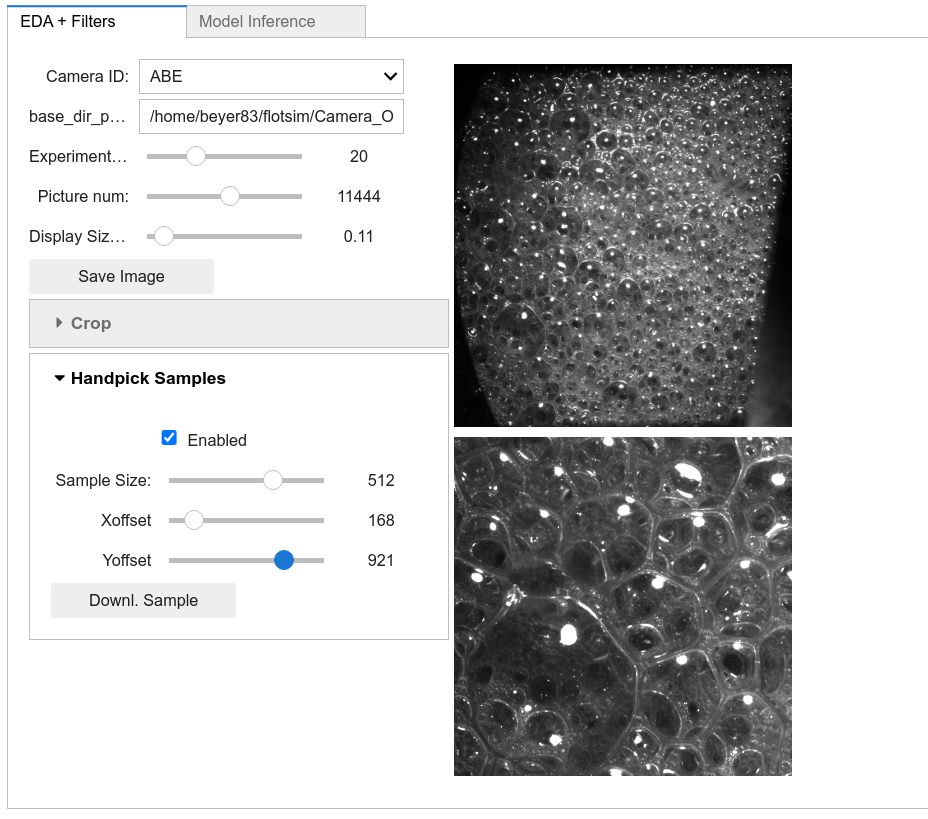

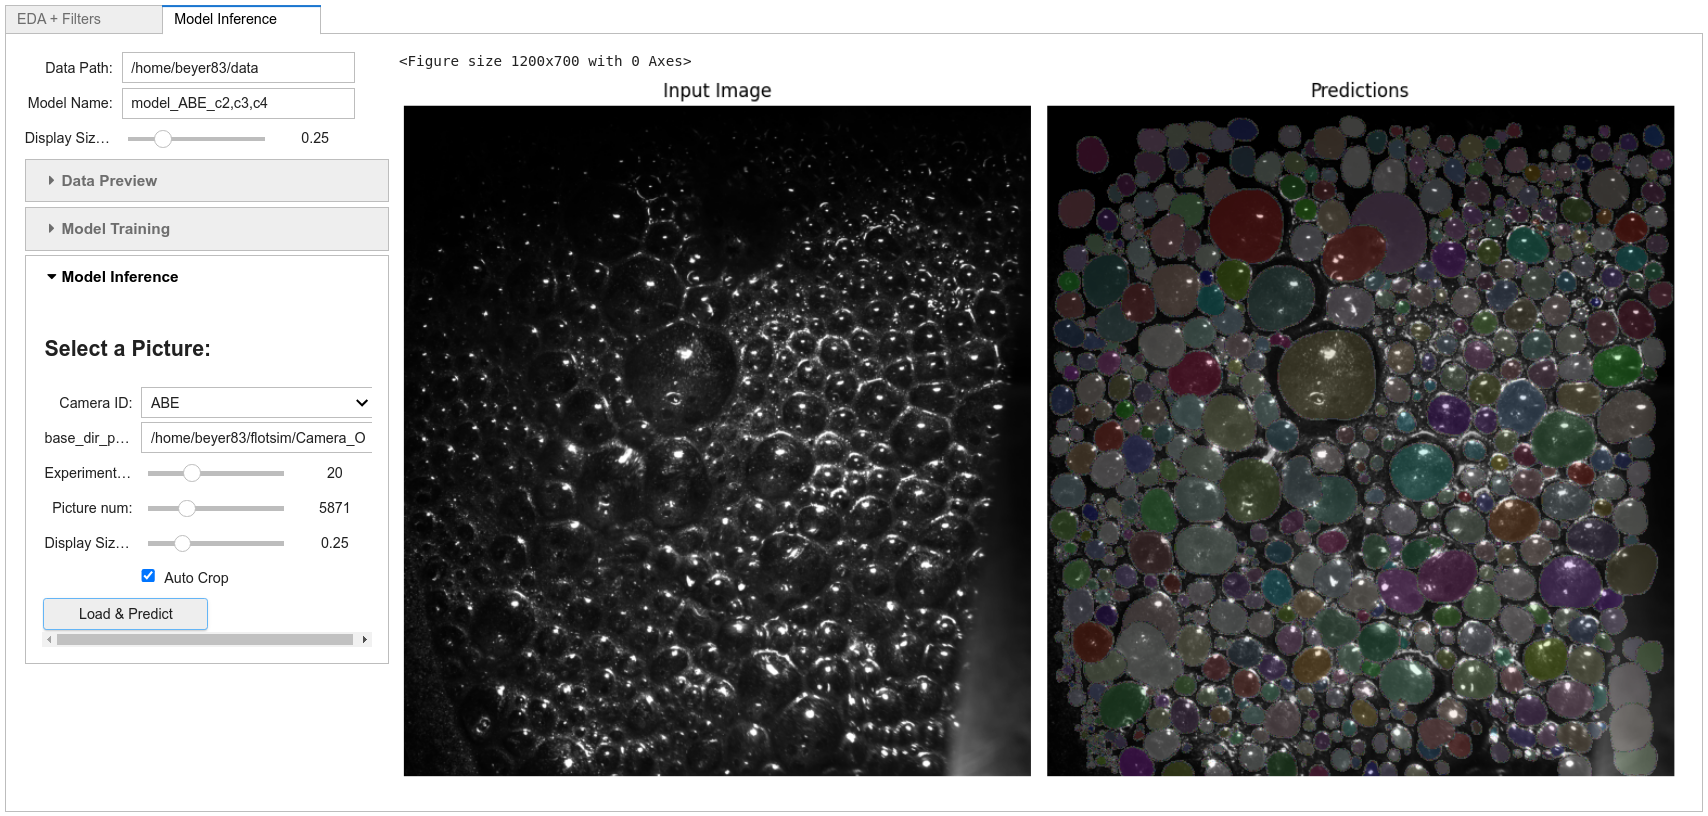